# Multivariate Gaussian Random Walk

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

import pymc3 as pm
import theano

np.random.seed(42)
%matplotlib inline

Simulate the data:

In [2]:
D = 3
N = 300
sections = 5
period = N/sections

Sigma_a = np.random.randn(D, D)
Sigma_a = Sigma_a.T.dot(Sigma_a)
L_a = cholesky(Sigma_a, lower=True)

Sigma_b = np.random.randn(D, D)
Sigma_b = Sigma_b.T.dot(Sigma_b)
L_b = cholesky(Sigma_b, lower=True)

# Gaussian Random walk:
alpha = np.cumsum(L_a.dot(np.random.randn(D, sections)), axis=1).T
beta = np.cumsum(L_b.dot(np.random.randn(D, sections)), axis=1).T
sigma = 0.1

t = np.arange(N)[:, None]/ N
alpha = np.repeat(alpha, period, axis=0)
beta = np.repeat(beta, period, axis=0)
y = alpha + beta*t + sigma*np.random.randn(N, 1)

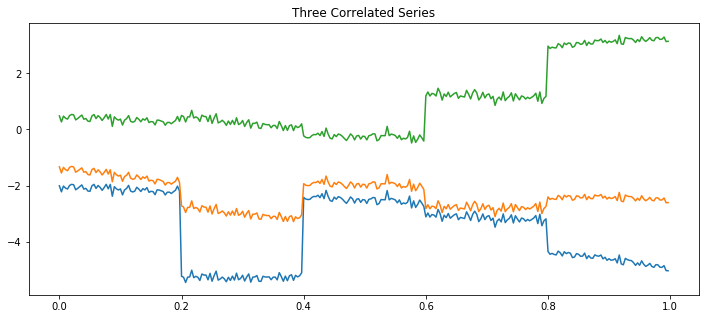

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(t, y)
plt.title('Three Correlated Series')
plt.show()

In [4]:
class Scaler():
    def __init__(self):
        mean_ = None
        std_ = None
    
    def transform(self, x):
        return (x - self.mean_) / self.std_
    
    def fit_transform(self, x):
        self.mean_ = x.mean(axis=0)
        self.std_ = x.std(axis=0)
        return self.transform(x)
    
    def inverse_transform(self, x):
        return x*self.std_ + self.mean_

In [5]:
def inference(t, y, sections, n_samples=100):
    N, D = y.shape
    
    # Standardies y and t
    y_scaler = Scaler()
    t_scaler = Scaler()
    y = y_scaler.fit_transform(y)
    t = t_scaler.fit_transform(t)
    # Create a section index
    t_section = np.repeat(np.arange(sections), N/sections)
    
    # Create theano equivalent
    t_t = theano.shared(np.repeat(t, D, axis=1))
    y_t = theano.shared(y)
    t_section_t = theano.shared(t_section)

    with pm.Model() as model:
        packed_L_α = pm.LKJCholeskyCov('packed_L_α', n=D,   
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        L_α = pm.expand_packed_triangular(D, packed_L_α)

        packed_L_β = pm.LKJCholeskyCov('packed_L_β', n=D,   
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        L_β = pm.expand_packed_triangular(D, packed_L_β)

        α = pm.MvGaussianRandomWalk('alpha', shape=(sections, D), chol=L_α)
        β = pm.MvGaussianRandomWalk('beta', shape=(sections, D), chol=L_β)
        alpha_r = α[t_section_t]
        beta_r = β[t_section_t]
        regression = alpha_r+beta_r*t_t

        sd = pm.Uniform('sd', 0, 1)
        likelihood = pm.Normal('y', mu=regression, sigma=sd, observed=y_t)
        trace = pm.sample(n_samples, cores=4)

    return trace, y_scaler, t_scaler, t_section

In [6]:
trace, y_scaler, t_scaler, t_section = inference(t, y, sections)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, alpha, packed_L_β, packed_L_α]
Sampling 4 chains: 100%|██████████| 2400/2400 [01:08<00:00, 35.03draws/s]


Predict the mean expected y value.

In [7]:
a_mean = trace['alpha'][-1000:].mean(axis=0)
b_mean = trace['beta'][-1000:].mean(axis=0)

y_pred = y_scaler.inverse_transform(a_mean[t_section] + b_mean[t_section]*t_scaler.transform(t))

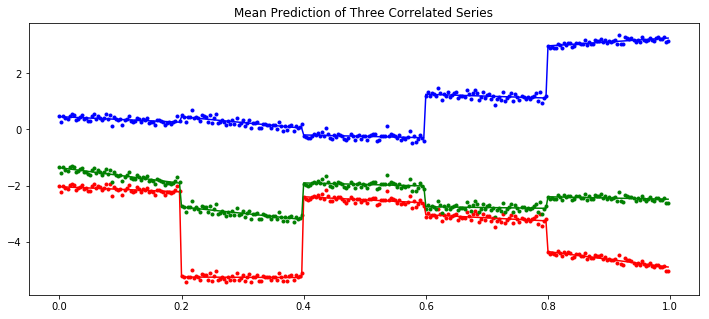

In [8]:
plt.figure(figsize=(12, 5))
plt.gca().set_prop_cycle('color', ['red', 'green', 'blue'])
plt.plot(t, y, '.')
plt.plot(t, y_pred)
plt.title('Mean Prediction of Three Correlated Series')
plt.show()